In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
from datetime import timedelta

import tqdm
from enflows.distributions import StandardNormal, Uniform, DiagonalNormal, MADEMoG, MOG
from enflows.transforms import Sigmoid, ScalarScale, ScalarShift, RandomPermutation, MaskedSumOfSigmoidsTransform, ConditionalSumOfSigmoidsTransform
from enflows.transforms.normalization import ActNorm
from enflows.transforms.base import CompositeTransform, InverseTransform
from enflows.transforms.lipschitz import LipschitzDenseNetBuilder, iResBlock
from enflows.nn.nets.activations import Sin
from enflows.nn.nets import ResidualNet
from enflows.flows.base import Flow
from enflows.transforms.injective import LpManifoldFlow, ConstrainedAnglesSigmoid, ClampedAngles, FixedNorm

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def set_random_seeds (seed=1234):
    np.random.seed(seed)
    torch.manual_seed(seed)

def uniform_p_norm (beta):
    return torch.ones_like(beta)

In [5]:
def spherical_to_cartesian_torch(arr):
    # meant for batches of vectors, i.e. arr.shape = (mb, n)
    
    assert arr.shape[1] >= 2
    r = arr[:, :1]
    angles = arr[:, 1:]
    
    sin_prods = torch.cumprod(torch.sin(angles), dim=1)
    x1 = r * torch.cos(angles[:, :1])
    xs = r * sin_prods[:, :-1] * torch.cos(angles[:, 1:])
    xn = r * sin_prods[:, -1:]

    return torch.cat((x1, xs, xn), dim=1)

def cartesian_to_spherical_torch(arr):
    # meant for batches of vectors, i.e. arr.shape = (mb, n)
    eps = 1e-5
    assert arr.shape[-1] >= 2
    radius = torch.linalg.norm(arr, dim=-1)
    flipped_cumsum = torch.cumsum(torch.flip(arr ** 2, dims=(-1,)), dim=-1)
    sqrt_sums = torch.flip(torch.sqrt(flipped_cumsum + eps), dims=(-1,))[...,:-1]
    angles = torch.acos(arr[..., :-1] / (sqrt_sums + eps))
    last_angle = ((arr[...,-1] >= 0).float() * angles[..., -1] + \
                (arr[...,-1] < 0).float() * (2 * np.pi - angles[..., -1]))

    return torch.cat((radius.unsqueeze(-1), angles[..., :-1], last_angle.unsqueeze(-1)), dim=-1)


In [6]:
# def log_prior_angles (beta:torch.Tensor, sigma:torch.Tensor):
#     eps = 1e-7
#     beta_spherical = cartesian_to_spherical_torch(beta)[...,1:]
#     theta_0_pi = (beta_spherical).square().sum(-1) / (sigma**2 + eps)
#     theta_pi__2 = (beta_spherical - 0.5 * np.pi).square().sum(-1) / (sigma**2 + eps)
#     theta_pi = (beta_spherical - np.pi).square().sum(-1) / (sigma**2 + eps)
# 
#     # theta_3_pi__2 = (beta_spherical[...,-1:] - 1.5 * np.pi).square().sum(-1) / (sigma**2 + eps)
#     # theta_2_pi = (beta_spherical[...,-1:] - 2 * np.pi).square().sum(-1) / (sigma**2 + eps)
# 
#     # prior_theta = - 0.5 * (theta_0_pi + theta_pi__2 + theta_pi)# + theta_3_pi__2 + theta_2_pi)
#     prior_theta = - 0.5 * (theta_0_pi + theta_pi)# + theta_3_pi__2 + theta_2_pi)
# 
#     return prior_theta

def log_prior_angles (beta:torch.Tensor, sigma:torch.Tensor):
    beta_spherical = cartesian_to_spherical_torch(beta)[...,1:]
    exp = []
    angles = [0.5 * np.pi]
    #angles = [0., 0.5*np.pi, 1.*np.pi, 1.5*np.pi, 2*np.pi]
    for mean in angles:
        #exp.append(normal_exp(beta_spherical[...,:-1], mean, sigma))
        #print("shape exp", normal_exp(beta_spherical[...,:-1], mean, sigma).shape)
        exp.append(normal_exp(beta_spherical[...,:-1], mean, sigma))
        print("shape exp", normal_exp(beta_spherical[...,:-1], mean, sigma).shape)
    angles = [1.5 * np.pi]
    #angles = [0., 0.5*np.pi, 1.*np.pi, 1.5*np.pi, 2*np.pi]
    for mean in angles:
        #exp.append(normal_exp(beta_spherical[...,:-1], mean, sigma))
        #print("shape exp", normal_exp(beta_spherical[...,:-1], mean, sigma).shape)
        exp.append(normal_exp(beta_spherical[...,-1:], mean, sigma))
        print("shape exp", normal_exp(beta_spherical[...,-1:], mean, sigma).shape)
    exp_torch = torch.cat(exp, dim=-1)
    # print("shape beta", beta_spherical.shape)
    # print("shape exp_torch", exp_torch.shape)
    # print("shape log_sum_exp", torch.logsumexp(exp_torch, dim=-1).shape)
    
    # const = torch.tensor(2*np.pi * sigma * len(angles) * beta_spherical[...,:-1].shape[-1])
    # const = torch.tensor(2*np.pi * sigma * len(angles) * beta_spherical.shape[-1])
    # const = torch.tensor(2*np.pi * sigma * len(angles))
    n_dim = beta_spherical[...,:-1].shape[-1]
    const = torch.tensor(2*np.pi * (sigma**2))
    return torch.logsumexp(exp_torch, dim=-1) - 0.5 * n_dim * torch.log(const) - torch.log(torch.tensor(len(angles)))
                   
    # theta_00_pi = torch.logsumexp( - 0.5 * (beta_spherical[...,:-1] / sigma ).square(), dim=-1) 
    # theta_05_pi = torch.logsumexp( - 0.5 * ((beta_spherical[...,:-1] - 0.5*np.pi) / sigma).square(), dim=-1) 
    # theta_10_pi = torch.logsumexp( - 0.5 * ((beta_spherical[...,:-1] - 1.0*np.pi) / sigma).square(), dim=-1)
    # 
    # #theta_15_pi = torch.logsumexp( - 0.5 * ((beta_spherical[...,-1:] - 1.5*np.pi) / (sigma + eps)).square(), dim=-1)
    # #theta_20_pi = torch.logsumexp( - 0.5 * ((beta_spherical[...,-1:] - 2.0*np.pi) / (sigma + eps)).square(), dim=-1)
    # 
    # prior_theta = theta_00_pi + theta_05_pi + theta_10_pi #+ theta_15_pi + theta_20_pi

    # return prior_theta

# def normal_exp (arr, mean, sigma):
#     return - 0.5 * ((arr - mean) / sigma ).square()
    
def normal_exp (arr, mean, sigma):
    return - 0.5 * ((arr - mean) / sigma ).square().sum(-1).unsqueeze(-1)

In [27]:
def build_flow_manifold (flow_dim, norm, q, n_layers=3, hidden_features=256, device='cuda'):
    # base distribution over flattened triangular matrix
    # base_dist = StandardNormal(shape=[flow_dim-1])
    
    means =  torch.tensor([[1.],[-1]]).repeat(1,flow_dim-1).to(device)
    stds = (torch.ones(means.shape[0],flow_dim-1) * 0.3).to(device)
    base_dist = MOG(means=means, stds=stds)
    
    # low = torch.tensor(-1.).to(device)
    # high = torch.tensor(1.).to(device)
    # base_dist = Uniform(shape=[flow_dim-1], low=low, high=high)

    # Define an invertible transformation
    transformation_layers = []

    for _ in range(n_layers):
        #transformation_layers.append(RandomPermutation(features=flow_dim-1))

        transformation_layers.append(
            InverseTransform(
                MaskedSumOfSigmoidsTransform(features=flow_dim-1, hidden_features=hidden_features, num_blocks=3, n_sigmoids=30)
            )
        )

        #transformation_layers.append(
        #InverseTransform(
        #        Sigmoid()
        #    )
        #)
        
        transformation_layers.append(
          InverseTransform(
              ActNorm(features=flow_dim-1)
          )
        )



    # transformation_layers.append(
    #    InverseTransform(
    #            CompositeTransform([
    #                ScalarScale(scale=2, trainable=False)])#,
    #                #ScalarShift(shift=-1, trainable=False)])
    #        )
    # )

    #transformation_layers.append(
    #   InverseTransform(
    #       Sigmoid()
    #   )
    #)

    transformation_layers.append(
        InverseTransform(
                ConstrainedAnglesSigmoid(temperature=1, learn_temperature=False)
            )
    )
    
    transformation_layers.append(
        InverseTransform(
            ClampedAngles(eps=1e-5)
        )
    )
    
    transformation_layers.append(
        InverseTransform(
            LpManifoldFlow(norm=norm, p=q)
            # FixedNorm(norm=norm, q=q)
        )
    )
    
    
    
    transformation_layers = transformation_layers[::-1]
    transform = CompositeTransform(transformation_layers)

    # combine into a flow
    flow = Flow(transform, base_dist).to(device)

    return flow

def build_flow_lipshitz_manifold (flow_dim, norm, q, n_layers=3, hidden_features=256, device='cuda'):
    # base distribution over flattened triangular matrix
    base_dist = StandardNormal(shape=[flow_dim-1])
    #low = torch.tensor(-1.).to(device)
    #high = torch.tensor(1.).to(device)
    #base_dist = Uniform(shape=[flow_dim-1], low=low, high=high)

    densenet_builder = LipschitzDenseNetBuilder(input_channels=flow_dim-1,
                                                densenet_depth=5,
                                                activation_function=Sin(w0=30),
                                                lip_coeff=.97,
                                                )

    transform_layers = []
    for i in range(n_layers):

        transform_layers.append(InverseTransform(iResBlock(densenet_builder.build_network(), brute_force=False)))
        transform_layers.append(InverseTransform(ActNorm(features=flow_dim-1)))
    
    transform_layers.append(
        InverseTransform(
                ConstrainedAnglesSigmoid()
            )
    )
    transform_layers.append(
        InverseTransform(
            FixedNorm(norm=norm, q=q)
        )
    )

    transform_layers = transform_layers[::-1]
    transform = CompositeTransform(transform_layers)

    flow = Flow(transform, base_dist).to(device)

    return flow

In [28]:
def train_model (model, epochs=2_001, lr=1e-3, sample_size=1, device="cuda", **kwargs):

    # optimizer = torch.optim.Adam([{'params':model.parameters()}, {'params':log_sigma, 'lr':1e-2}], lr=lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    loss = []
    try:
        start_time = time.monotonic()
        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            q_samples, q_log_prob = model.sample_and_log_prob(num_samples=sample_size)
            if torch.any(torch.isnan(q_samples)): breakpoint()
            
            # log_lik = uniform_p_norm(beta=q_log_prob_beta)
            # kl_div = torch.mean(q_log_prob_beta - log_lik)
            # kl_div.backward()

            #assert not torch.any(torch.isnan(q_log_prob))

            log_prior = log_prior_angles(q_samples, torch.tensor(0.5))
            assert not torch.any(torch.isnan(log_prior))
            kl_div = torch.mean(q_log_prob - log_prior)
            #kl_div = torch.mean(q_log_prob)
            kl_div.backward()
            
            #torch.nn.utils.clip_grad_norm_(model.parameters(), .001)
            optimizer.step()

            # loss.append(torch.mean(q_log_prob_beta - log_lik).cpu().detach().numpy())
            #loss.append(torch.mean(q_log_prob).cpu().detach().numpy())
            loss.append(torch.mean(q_log_prob - log_prior).cpu().detach().numpy())

            print(f"Training loss at step {epoch}: {loss[-1]:.4f}")
            if epoch % 25 == 0:
                
                q_log_prob_np = q_log_prob.detach().cpu().numpy().ravel()
                q_samples_np = q_samples.detach().cpu().numpy()
                samples_spherical = cartesian_to_spherical_torch(torch.tensor(q_samples_np)).numpy()
                for i in range(1, samples_spherical.shape[1]):
                    # plt.figure(figsize=(10,5))
                    # plt.scatter(samples_spherical[:,i], q_log_prob_np, marker='.')
                    # plt.show()
                    # plt.clf()

                    plt.figure(figsize=(10,5))
                    plt.hist(samples_spherical[:,i], bins=25)
                    #n, bins, patches = plt.hist(samples_spherical[:,i], bins=25)
                    #plt.vlines([0, np.pi * 0.5, np.pi, np.pi*1.5, 2 * np.pi], ymin=0, ymax=max(n), linestyles='dashed', colors='b')
                    # plt.savefig(f"{dir_name}samples_p{q}_theta_flow.pdf", dpi=100)
                    plt.xlim(0, 2*np.pi)
                    plt.show()
                    plt.clf()

    except KeyboardInterrupt:
        print("interrupted..")

    end_time = time.monotonic()
    time_diff = timedelta(seconds=end_time - start_time)
    print(f"Training took {time_diff} seconds")

    return model, loss

In [29]:
def sample_beta (model, sample_size=100, n_iter=500, device='cuda'):
    # Sample from approximate posterior & estimate significant edges via  posterior credible interval
    samples = []
    for _ in tqdm.tqdm(range(n_iter)):
        posterior_samples, log_probs_samples = model.sample_and_log_prob(sample_size)
        samples.append(posterior_samples.cpu().detach().numpy())

    return np.concatenate(samples, 0)

In [30]:
import os
dir_name = "./plots/"
if not os.path.exists(dir_name):
    # If it doesn't exist, create it
    os.makedirs(dir_name)

In [31]:
device = 'cuda'
set_random_seeds(123)

# Build Model
flow_dim = 5
q = 1
norm = 1
flow = build_flow_manifold(flow_dim, norm=norm, q=q, n_layers=3, hidden_features=64, device=device)
#flow = build_flow_lipshitz_manifold(flow_dim, norm=norm, q=q, n_layers=3, hidden_features=64, device=device)

params = dict(lr=1e-3,
              epochs=201,
              sample_size=1_000,
              device=device)

shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 0: 6.4126


/tmp/ipykernel_2374589/498530099.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  const = torch.tensor(2*np.pi * (sigma**2))


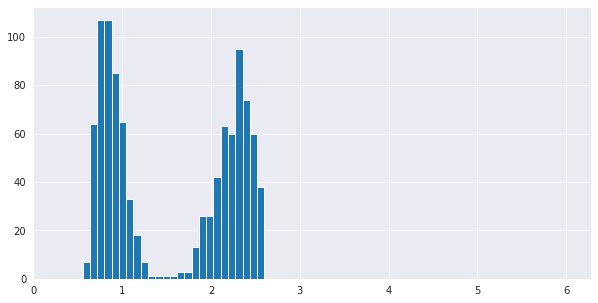

<Figure size 432x288 with 0 Axes>

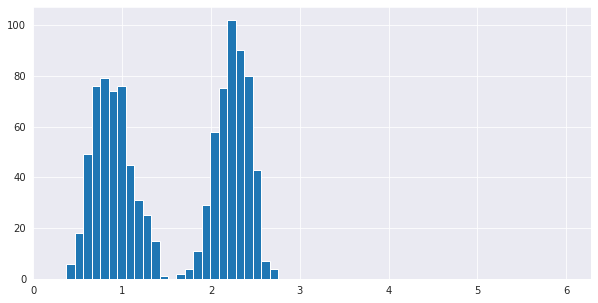

<Figure size 432x288 with 0 Axes>

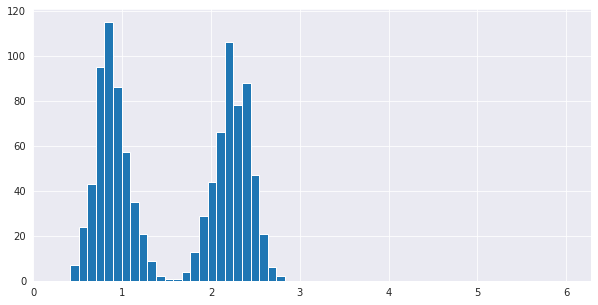

<Figure size 432x288 with 0 Axes>

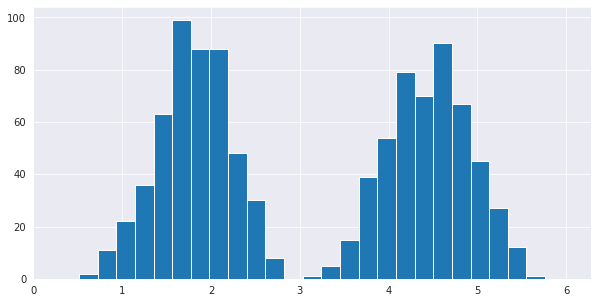

shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 1: 5.9425
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 2: 5.4019
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 3: 4.8854
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 4: 4.5862
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 5: 4.2594
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 6: 3.9706
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 7: 3.7816
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 8: 3.5962
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 9: 3.4408
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 10: 3.1761
shape exp torch.Size([1000, 1])
shape e

<Figure size 432x288 with 0 Axes>

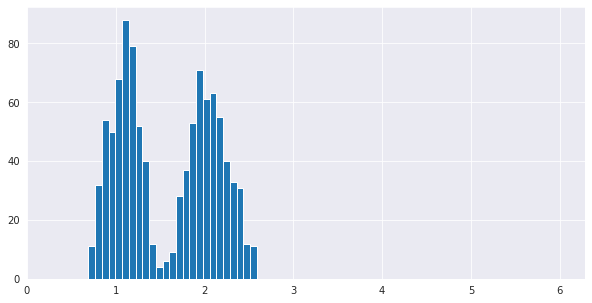

<Figure size 432x288 with 0 Axes>

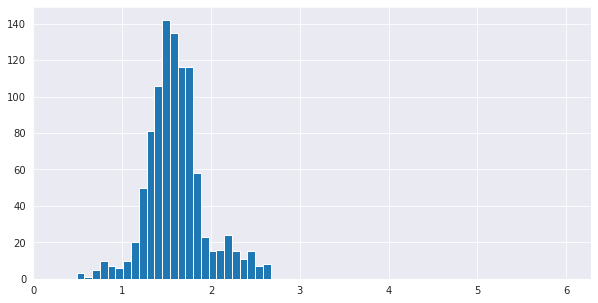

<Figure size 432x288 with 0 Axes>

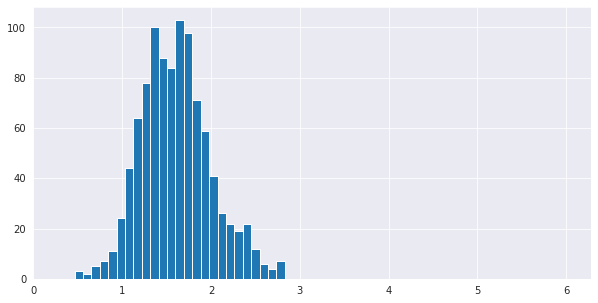

<Figure size 432x288 with 0 Axes>

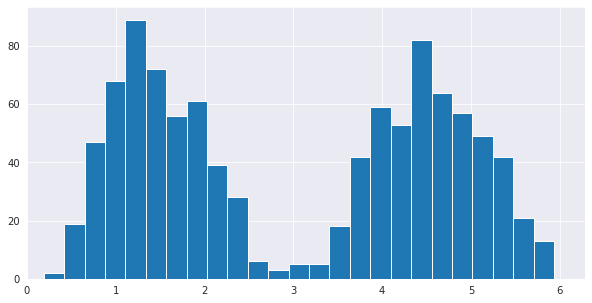

shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 26: 2.5327
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 27: 2.5934
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 28: 2.5383
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 29: 2.4442
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 30: 2.2829
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 31: 2.3567
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 32: 2.3080
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 33: 2.2708
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 34: 2.2748
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 35: 2.2783
shape exp torch.Size([1000, 1]

<Figure size 432x288 with 0 Axes>

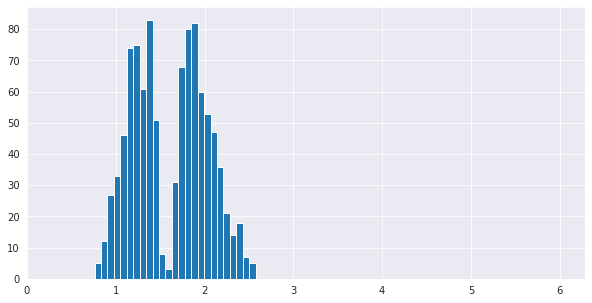

<Figure size 432x288 with 0 Axes>

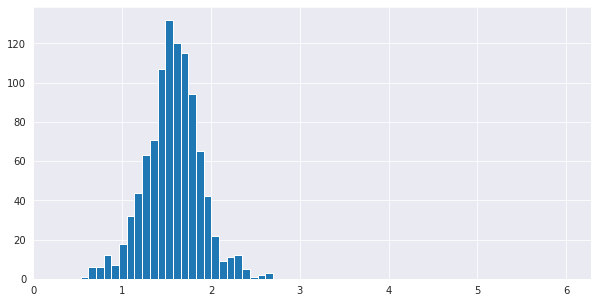

<Figure size 432x288 with 0 Axes>

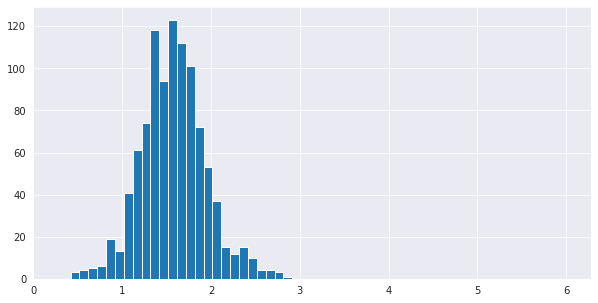

<Figure size 432x288 with 0 Axes>

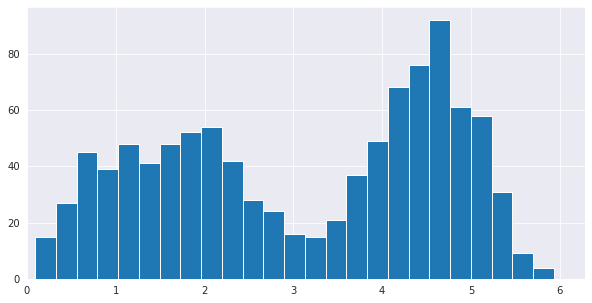

shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 51: 2.0594
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 52: 2.0254
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 53: 2.0495
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 54: 2.0360
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 55: 2.0026
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 56: 2.0334
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 57: 2.0377
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 58: 1.9961
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 59: 1.9359
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 60: 1.9787
shape exp torch.Size([1000, 1]

<Figure size 432x288 with 0 Axes>

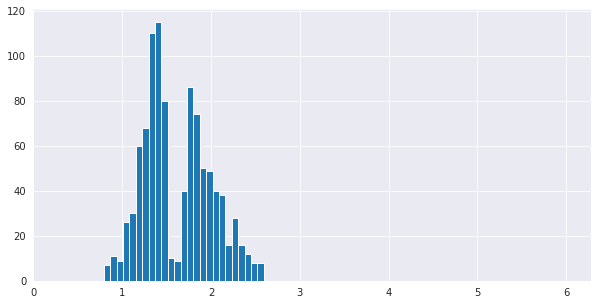

<Figure size 432x288 with 0 Axes>

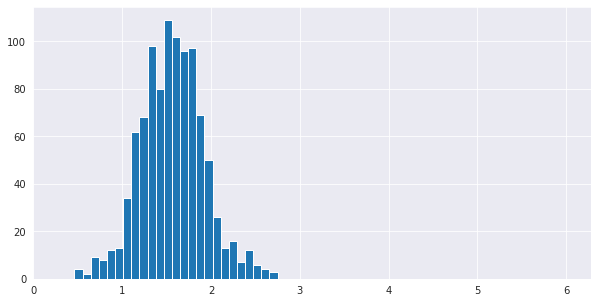

<Figure size 432x288 with 0 Axes>

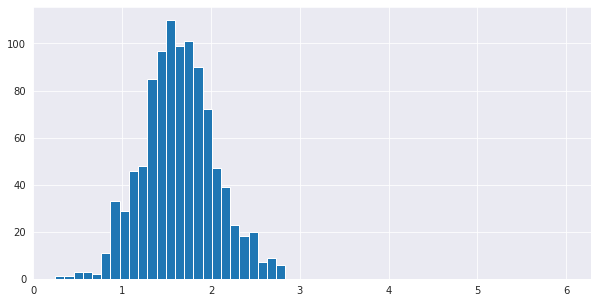

<Figure size 432x288 with 0 Axes>

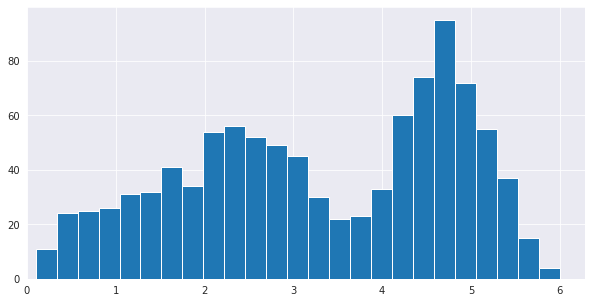

shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 76: 1.8061
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 77: 1.7662
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 78: 1.7335
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 79: 1.7816
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 80: 1.7608
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 81: 1.7682
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 82: 1.7103
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 83: 1.7603
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 84: 1.6946
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 85: 1.6771
shape exp torch.Size([1000, 1]

<Figure size 432x288 with 0 Axes>

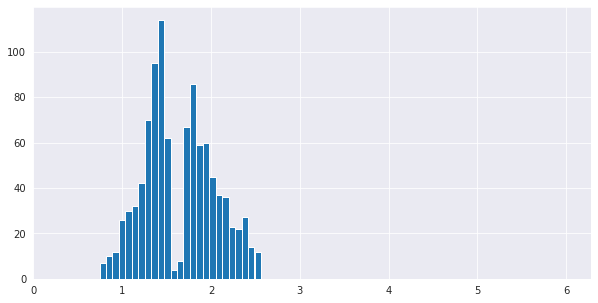

<Figure size 432x288 with 0 Axes>

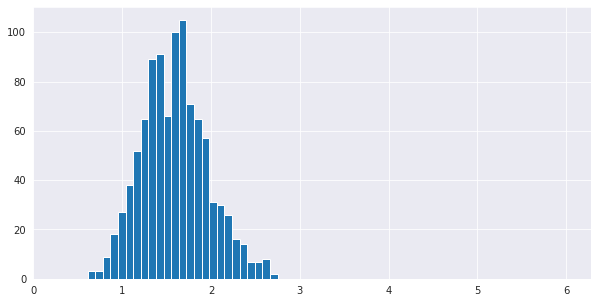

<Figure size 432x288 with 0 Axes>

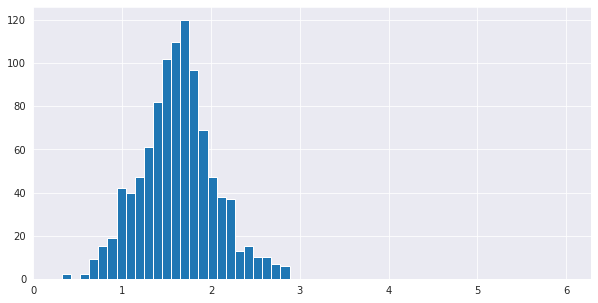

<Figure size 432x288 with 0 Axes>

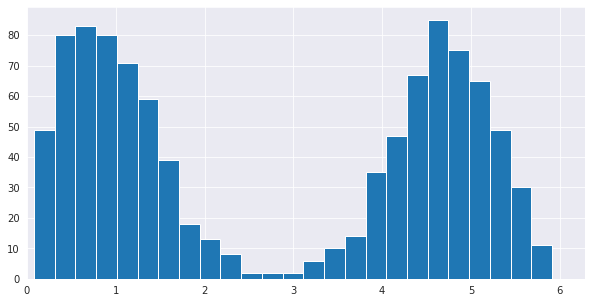

shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 101: 1.9687
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 102: 1.9360
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 103: 1.9034
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 104: 1.9310
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 105: 1.8943
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 106: 1.9199
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 107: 1.9011
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 108: 1.8853
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 109: 1.8664
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 110: 1.9299
shape exp torch.Size

<Figure size 432x288 with 0 Axes>

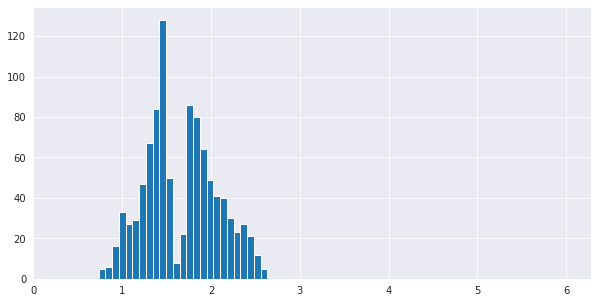

<Figure size 432x288 with 0 Axes>

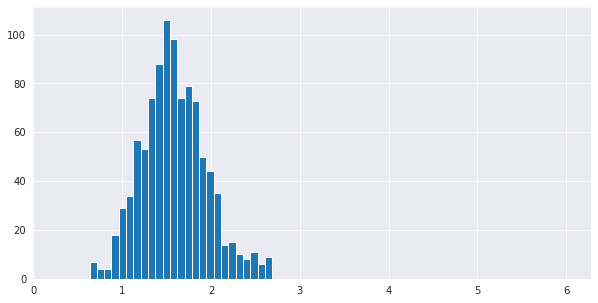

<Figure size 432x288 with 0 Axes>

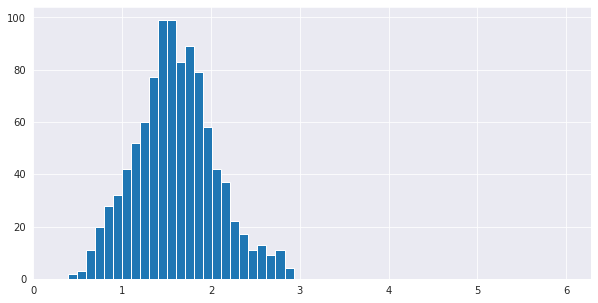

<Figure size 432x288 with 0 Axes>

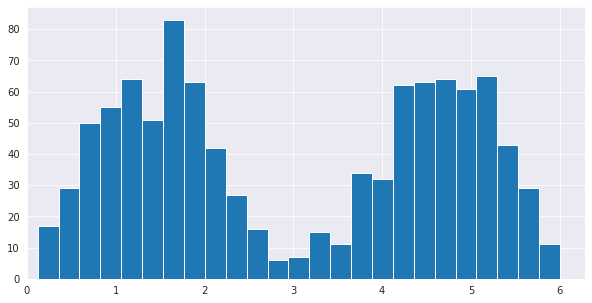

shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 126: 1.7847
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 127: 1.7461
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 128: 1.7664
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 129: 1.7467
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 130: 1.7929
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 131: 1.7492
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 132: 1.7346
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 133: 1.7915
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 134: 1.7309
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 135: 1.7358
shape exp torch.Size

<Figure size 432x288 with 0 Axes>

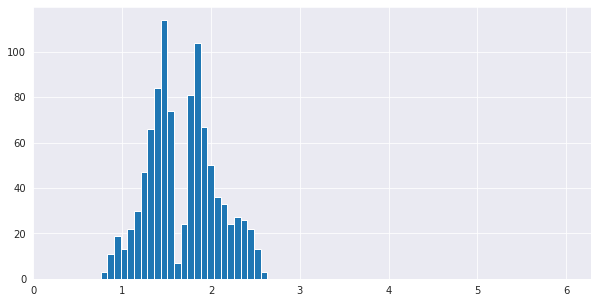

<Figure size 432x288 with 0 Axes>

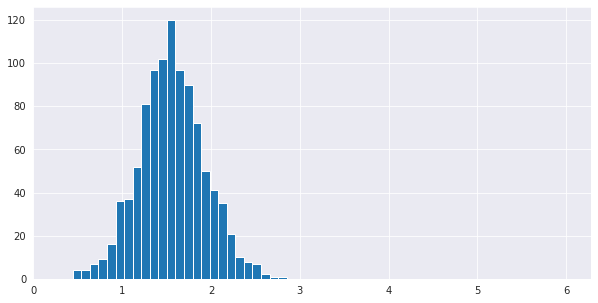

<Figure size 432x288 with 0 Axes>

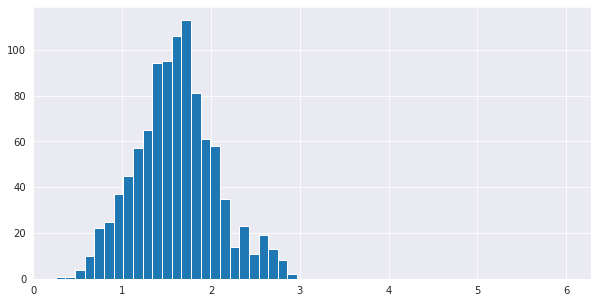

<Figure size 432x288 with 0 Axes>

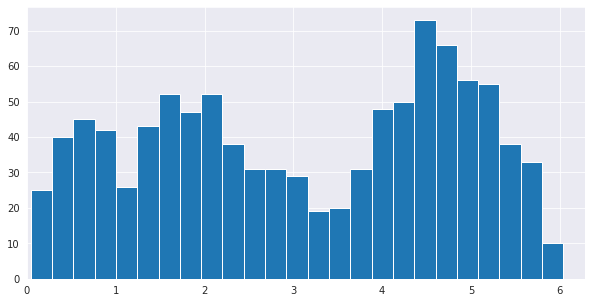

shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 151: 1.6418
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 152: 1.6282
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 153: 1.6225
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 154: 1.6010
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 155: 1.6172
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 156: 1.5973
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 157: 1.6597
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 158: 1.6200
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 159: 1.7660
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 160: 2.1044
shape exp torch.Size

<Figure size 432x288 with 0 Axes>

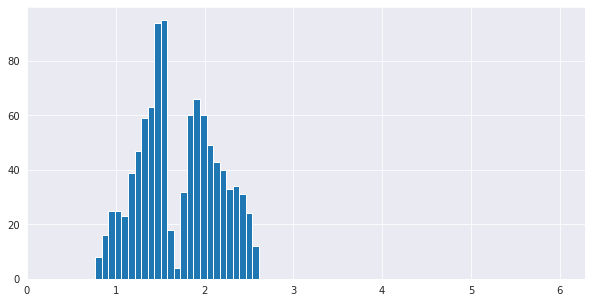

<Figure size 432x288 with 0 Axes>

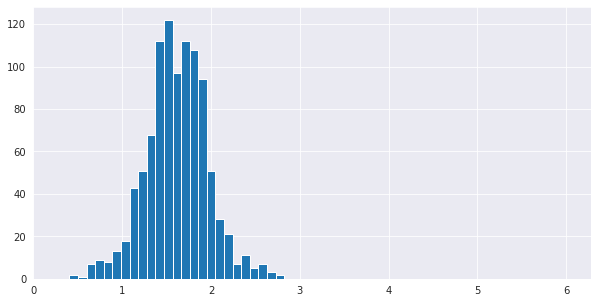

<Figure size 432x288 with 0 Axes>

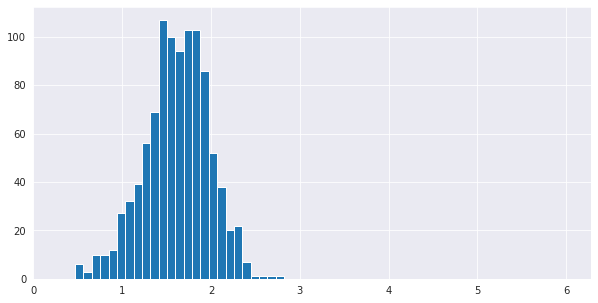

<Figure size 432x288 with 0 Axes>

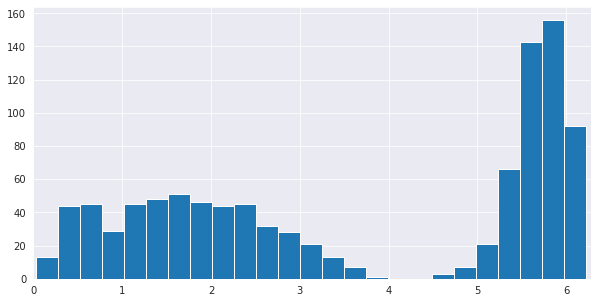

shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 176: 2.5595
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 177: 2.5188
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 178: 2.4948
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 179: 2.5098
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 180: 2.4717
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 181: 2.4266
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 182: 2.3355
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 183: 2.3711
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 184: 2.4068
shape exp torch.Size([1000, 1])
shape exp torch.Size([1000, 1])
Training loss at step 185: 2.3141
shape exp torch.Size

<Figure size 432x288 with 0 Axes>

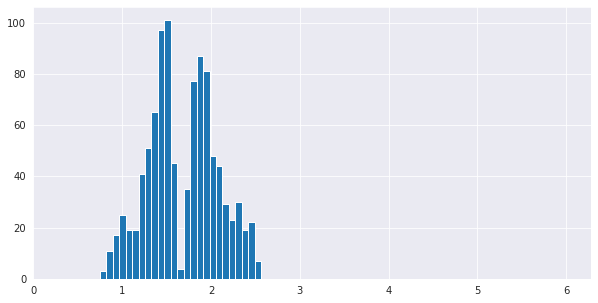

<Figure size 432x288 with 0 Axes>

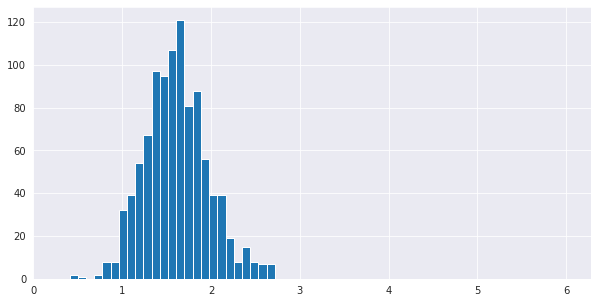

<Figure size 432x288 with 0 Axes>

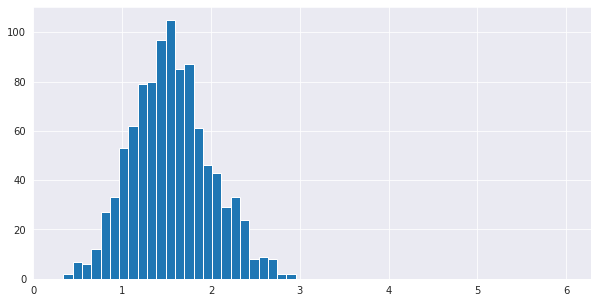

<Figure size 432x288 with 0 Axes>

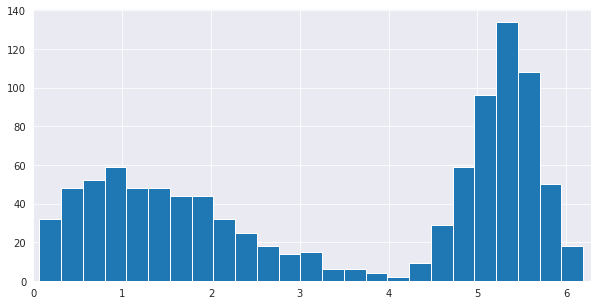

Training took 0:00:15.437869 seconds


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): InverseTransform(
        (_transform): FixedNorm(
          (sph_to_cart_jac): SymPyModule(expressions=(-r*sin(theta_1), 0, 0, 0, cos(theta_1), r*cos(theta_1)*cos(theta_2), -r*sin(theta_1)*sin(theta_2), 0, 0, sin(theta_1)*cos(theta_2), r*sin(theta_2)*cos(theta_1)*cos(theta_3), r*sin(theta_1)*cos(theta_2)*cos(theta_3), -r*sin(theta_1)*sin(theta_2)*sin(theta_3), 0, sin(theta_1)*sin(theta_2)*cos(theta_3), r*sin(theta_2)*sin(theta_3)*cos(theta_1)*cos(theta_4), r*sin(theta_1)*sin(theta_3)*cos(theta_2)*cos(theta_4), r*sin(theta_1)*sin(theta_2)*cos(theta_3)*cos(theta_4), -r*sin(theta_1)*sin(theta_2)*sin(theta_3)*sin(theta_4), sin(theta_1)*sin(theta_2)*sin(theta_3)*cos(theta_4), r*sin(theta_2)*sin(theta_3)*sin(theta_4)*cos(theta_1), r*sin(theta_1)*sin(theta_3)*sin(theta_4)*cos(theta_2), r*sin(theta_1)*sin(theta_2)*sin(theta_4)*cos(theta_3), r*sin(theta_1)*sin(theta_2)*sin(theta_3)*cos(theta_4), sin(theta_1)*si

<Figure size 432x288 with 0 Axes>

In [32]:
torch.autograd.set_detect_anomaly(False)
flow, loss = train_model(flow, **params)
flow.eval()

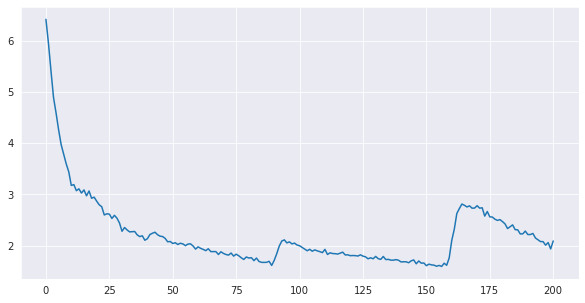

In [33]:
plt.figure(figsize=(10,5))
plt.plot(range(len(loss)), loss)
plt.show()

In [34]:
n_samples = 10_000# 50_000
n_samples_plot = 1000
samples = sample_beta (flow, sample_size=n_samples//20, n_iter=20, device=device)
samples_reshaped = samples.reshape(-1, flow_dim)

100%|██████████| 20/20 [00:00<00:00, 63.84it/s]


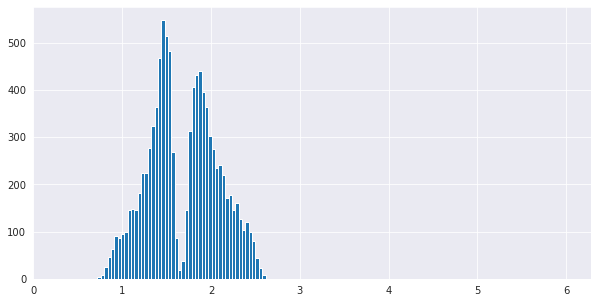

<Figure size 432x288 with 0 Axes>

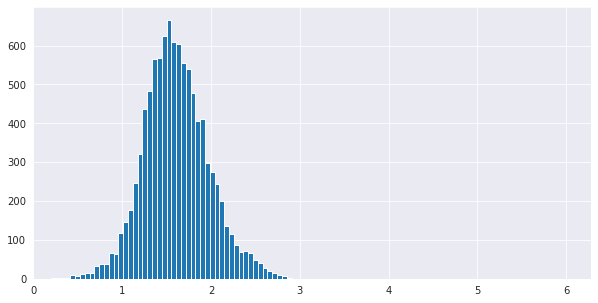

<Figure size 432x288 with 0 Axes>

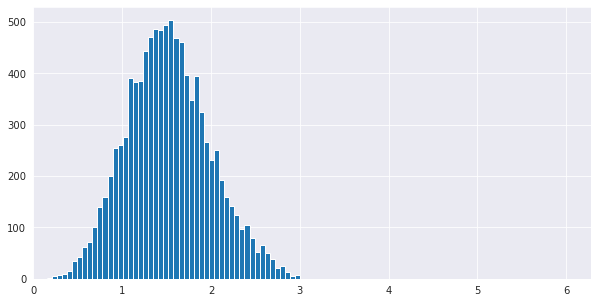

<Figure size 432x288 with 0 Axes>

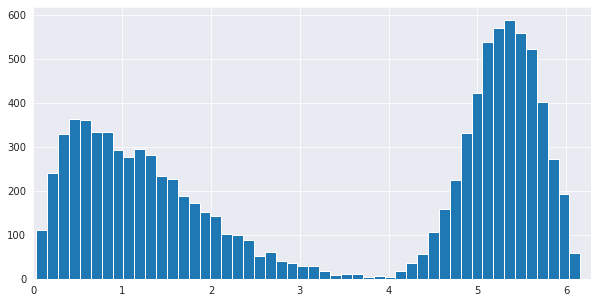

<Figure size 432x288 with 0 Axes>

In [35]:
samples_spherical = cartesian_to_spherical_torch(torch.tensor(samples)).numpy()
for i in range(1, samples_spherical.shape[1]):
    plt.figure(figsize=(10,5))
    #n, bins, patches = plt.hist(samples_spherical[:,i], bins=50)
    plt.hist(samples_spherical[:,i], bins=50)
    plt.vlines([0, np.pi * 0.5, np.pi, np.pi*1.5, 2 * np.pi], ymin=0, ymax=400, linestyles='dashed', colors='b', edgecolor = "none")
    #plt.savefig(f"{dir_name}samples_p{q}_theta_flow_prior_angles_{i}.pdf", dpi=100)
    plt.xlim(0, 2*np.pi)
    plt.show()
    plt.clf()

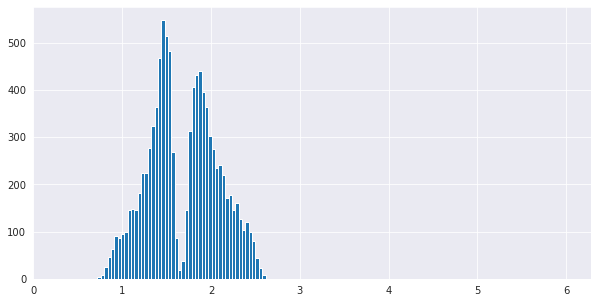

<Figure size 432x288 with 0 Axes>

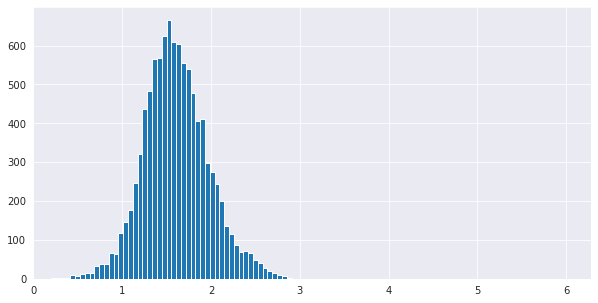

<Figure size 432x288 with 0 Axes>

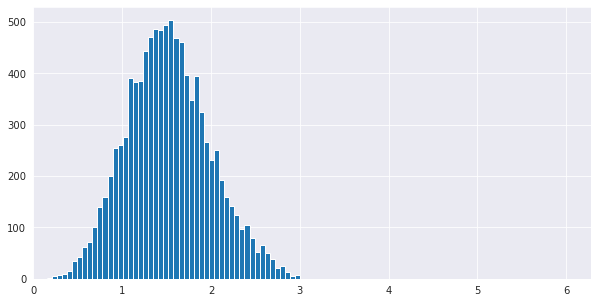

<Figure size 432x288 with 0 Axes>

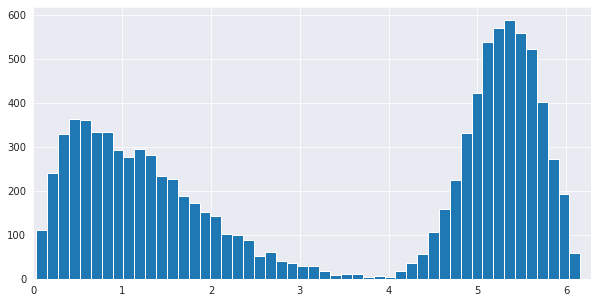

<Figure size 432x288 with 0 Axes>

In [36]:
samples_spherical = cartesian_to_spherical_torch(torch.tensor(samples)).numpy()
for i in range(1, samples_spherical.shape[1]):
    plt.figure(figsize=(10,5))
    #n, bins, patches = plt.hist(samples_spherical[:,i], bins=50)
    plt.hist(samples_spherical[:,i], bins=50)
    plt.vlines([0, np.pi * 0.5, np.pi, np.pi*1.5, 2 * np.pi], ymin=0, ymax=400, linestyles='dashed', colors='b', edgecolor = "none")
    #plt.savefig(f"{dir_name}samples_p{q}_theta_flow_prior_angles_{i}.pdf", dpi=100)
    plt.xlim(0, 2*np.pi)
    plt.show()
    plt.clf()

In [22]:
def lp_norm(arr, p):
    norm = np.sum(np.power(np.abs(arr), p), 1)
    norm = np.power(norm, 1/p).reshape(-1,1)
    return arr/norm

In [23]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [121]:
from rpy2.robjects.packages import importr
rpgnorm = importr('pgnorm')
q=1
n_samples = 50000
flow_dim = 10
%R -i q -i flow_dim -i n_samples -o samples samples <- rpgnorm(n_samples * flow_dim, q)
samples = np.array(samples).reshape(-1,flow_dim)
samples_norm = lp_norm(samples, q)

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


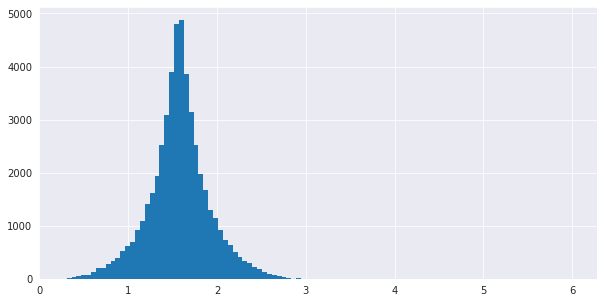

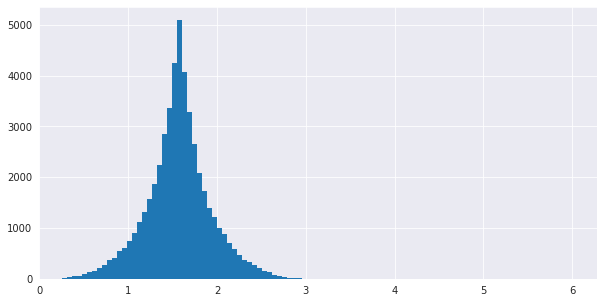

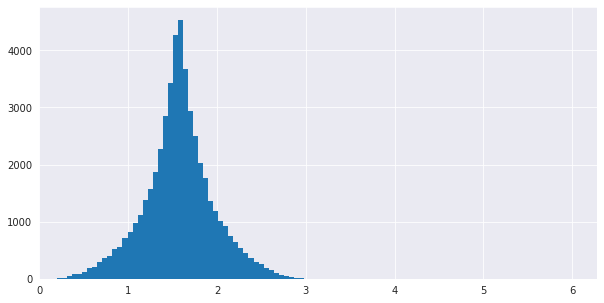

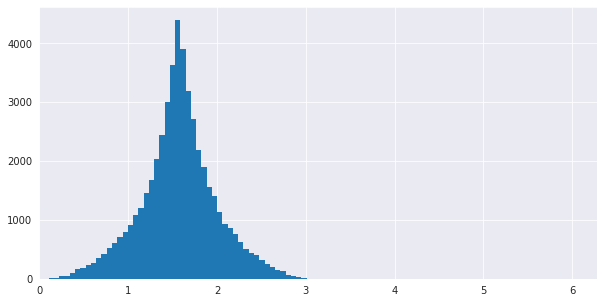

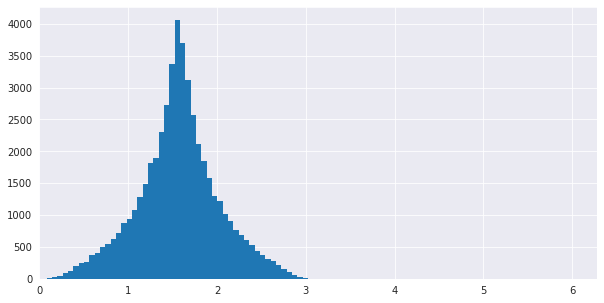

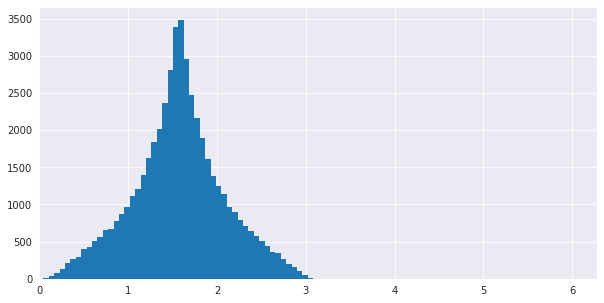

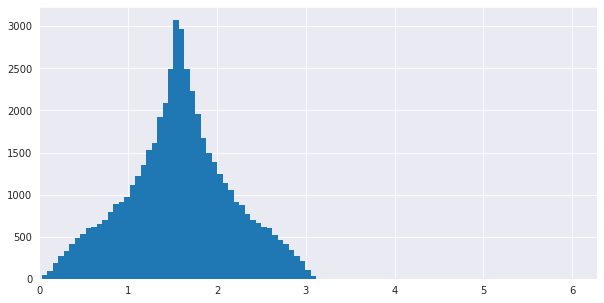

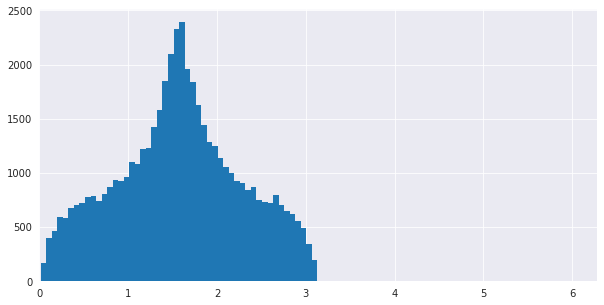

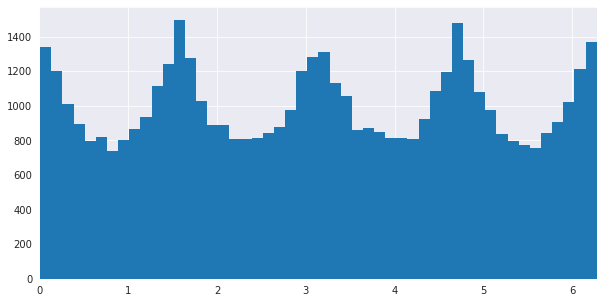

In [122]:
samples_spherical = cartesian_to_spherical_torch(torch.from_numpy(samples_norm)).numpy()
for i in range(1, samples_spherical.shape[1]):
    plt.figure(figsize=(10,5))
    # n, bins, patches = plt.hist(samples_spherical[:,i], bins=200)
    plt.hist(samples_spherical[:,i], bins=50, edgecolor = "none")
    #plt.vlines([0, np.pi * 0.5, np.pi, np.pi*1.5, 2 * np.pi], ymin=0, ymax=max(n), linestyles='dashed', colors='b')
    # plt.savefig(f"{dir_name}samples_p{q}_theta_gt.pdf", dpi=100)
    plt.xlim(0,2*np.pi)
    plt.show()